In [ ]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
client = bigquery.Client()
project_id = 'code-for-planet'
dataset_id = 'emission_db'
table_id = 'emissions_final_imputed'

essential_columns = [
    'event_duration_days', 'year', 'doy', 'longitude', 'latitude',
    'covertype', 'fuelcode', 'prefire_fuel',
    'cwd_frac', 'duff_frac', 'fuel_moisture_class',
    'burn_source', 'burnday_source', 'BSEV',
    'fire_region', 'bi_value', 'fm100_value', 'pet_value', 'fm1000_value',
    'pr_value', 'rmax_value', 'rmin_value', 'sph_value', 'srad_value',
    'tmmn_value', 'th_value', 'tmmx_value', 'vpd_value', 'vs_value',
    'fire_date'
]

query = f"""
SELECT {', '.join(essential_columns)}
FROM `{project_id}.{dataset_id}.{table_id}`
WHERE event_duration_days IS NOT NULL
"""

query_job = client.query(query)
df = query_job.to_dataframe()

In [ ]:
for col in df.columns:
    col_type = df[col].dtype
    if col_type != 'object':
        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')

In [ ]:
df['duration'] = df['event_duration_days'].astype('float32')
df['month'] = pd.to_datetime(df['fire_date']).dt.month.astype('int8')
df['season'] = (pd.to_datetime(df['fire_date']).dt.month%12 // 3 + 1).astype('int8')
df['day_of_year_sin'] = np.sin(2 * np.pi * df['doy'] / 365.25).astype('float32')
df['day_of_year_cos'] = np.cos(2 * np.pi * df['doy'] / 365.25).astype('float32')

df.drop('fire_date', axis=1, inplace=True)

In [ ]:
categorical_features = [
    'covertype', 'fuelcode', 'fuel_moisture_class',
    'burn_source', 'burnday_source', 'BSEV',
]

numerical_features = [
    'longitude', 'latitude', 'prefire_fuel',
    'cwd_frac', 'duff_frac', 'bi_value', 'fm100_value',
    'pet_value', 'fm1000_value', 'pr_value', 'rmax_value', 'rmin_value',
    'sph_value', 'srad_value', 'tmmn_value', 'th_value', 'tmmx_value',
    'vpd_value', 'vs_value',
    'month', 'season', 'day_of_year_sin', 'day_of_year_cos'
]

In [ ]:
label_encoders = {}

for cat_feature in categorical_features:
    if cat_feature in df.columns:
        le = LabelEncoder()
        df[cat_feature] = df[cat_feature].fillna('missing')
        df[cat_feature] = le.fit_transform(df[cat_feature].astype(str)).astype('int16')
        label_encoders[cat_feature] = le

In [ ]:
feature_columns = [col for col in numerical_features + categorical_features if col in df.columns]
df_clean = df.dropna(subset=['duration'])

In [ ]:
pearson_scores = df_clean[feature_columns].corrwith(df_clean['duration']).abs()

spearman_scores = []
for col in feature_columns:
    mask = df_clean[col].notna() & df_clean['duration'].notna()
    if mask.sum() > 0:
        corr, _ = spearmanr(df_clean.loc[mask, col], df_clean.loc[mask, 'duration'])
        spearman_scores.append(abs(corr) if not np.isnan(corr) else 0)
    else:
        spearman_scores.append(0)

spearman_scores = pd.Series(spearman_scores, index=feature_columns)

feature_scores = pd.DataFrame(index=feature_columns)
feature_scores['pearson_correlation'] = pearson_scores
feature_scores['spearman_correlation'] = spearman_scores

In [ ]:
sample_size = min(100000, len(df_clean))
df_sample = df_clean[feature_columns + ['duration']].dropna()
if len(df_sample) > sample_size:
    df_sample = df_sample.sample(n=sample_size, random_state=42)

mi_scores = mutual_info_regression(
    df_sample[feature_columns],
    df_sample['duration'],
    random_state=42
)
feature_scores['mutual_information'] = pd.Series(mi_scores, index=feature_columns)

In [ ]:
df_complete = df_clean[feature_columns + ['duration']].dropna()
if len(df_complete) > 0:
    f_selector = SelectKBest(score_func=f_regression, k='all')
    f_selector.fit(df_complete[feature_columns], df_complete['duration'])
    feature_scores['anova_f'] = pd.Series(f_selector.scores_, index=feature_columns)
else:
    feature_scores['anova_f'] = pd.Series([np.nan] * len(feature_columns), index=feature_columns)

In [ ]:
numerical_cols = [col for col in numerical_features if col in df_clean.columns]
scaler_vif = StandardScaler()
df_vif = df_clean[numerical_cols].dropna()
df_vif_scaled = pd.DataFrame(
    scaler_vif.fit_transform(df_vif),
    columns=numerical_cols,
    index=df_vif.index
)

vif_data = pd.DataFrame()
vif_data["Feature"] = numerical_cols
vif_scores = []

for i in range(len(numerical_cols)):
    try:
        vif = variance_inflation_factor(df_vif_scaled.values, i)
        vif_scores.append(vif)
    except:
        vif_scores.append(np.nan)

vif_data["VIF"] = vif_scores
vif_data = vif_data.sort_values('VIF', ascending=False)


vif_dict = dict(zip(vif_data['Feature'], 1 / (vif_data['VIF'] + 1)))
feature_scores['vif_score'] = pd.Series(vif_dict).reindex(feature_columns).fillna(0)

In [ ]:
rankings = pd.DataFrame(index=feature_columns)
methods = ['pearson_correlation', 'spearman_correlation', 'mutual_information', 'anova_f', 'vif_score']

for method in methods:
    if method in feature_scores.columns:
        scores = feature_scores[method]
        scores_clean = scores.fillna(0)
        rankings[f'{method}_score'] = scores_clean
        rankings[f'{method}_rank'] = scores_clean.rank(ascending=False)

rank_columns = [col for col in rankings.columns if '_rank' in col]
rankings['avg_rank'] = rankings[rank_columns].mean(axis=1)
rankings['final_rank'] = rankings['avg_rank'].rank()

score_columns = [col for col in rankings.columns if '_score' in col]
rankings['avg_score'] = rankings[score_columns].mean(axis=1)

rankings_sorted = rankings.sort_values('final_rank')

In [ ]:
score_columns = [col for col in rankings.columns if '_score' in col and col != 'avg_score']
normalized_scores = rankings[score_columns].copy()

for col in score_columns:
    col_min = normalized_scores[col].min()
    col_max = normalized_scores[col].max()
    if col_max > col_min:
        normalized_scores[col] = (normalized_scores[col] - col_min) / (col_max - col_min)
    else:
        normalized_scores[col] = 0

Adjusted for normalized scores

In [ ]:
score_columns = [col for col in rankings.columns if '_score' in col and col != 'avg_score']
normalized_scores = rankings[score_columns].copy()

for col in score_columns:
    col_min = normalized_scores[col].min()
    col_max = normalized_scores[col].max()
    if col_max > col_min:
        normalized_scores[col] = (normalized_scores[col] - col_min) / (col_max - col_min)
    else:
        normalized_scores[col] = 0.5

rankings['avg_score_norm'] = normalized_scores.mean(axis=1)

rankings_sorted = rankings.sort_values('avg_score_norm', ascending=False)


In [ ]:
correlation_summary = feature_scores[['pearson_correlation', 'spearman_correlation']].copy()
correlation_summary['avg_correlation'] = correlation_summary.mean(axis=1)
correlation_summary = correlation_summary.sort_values('avg_correlation', ascending=False)

print("Top Features by Correlation (Pearson & Spearman):")
print(correlation_summary.head(10).round(3))
print("\n")

mi_summary = feature_scores[['mutual_information']].sort_values('mutual_information', ascending=False)
print("Top Features by Mutual Information:")
print(mi_summary.head(10).round(4))
print("\n")

anova_summary = feature_scores[['anova_f']].sort_values('anova_f', ascending=False)
print("Top Features by ANOVA F-test Score:")
print(anova_summary.head(10).round(2))
print("\n")

print("Top Features by VIF (Low VIF indicates low multicollinearity):")
print(vif_data.head(29))
print("\n")

print("=" * 60)
print("OVERALL FEATURE SELECTION SUMMARY")
print("=" * 60)
print(f"Total features analyzed: {len(feature_columns)}")
print("\nTop 10 features by combined ranking (all methods):")

for i, (feat, rank) in enumerate(rankings_sorted['avg_rank'].head(29).items()):
    scores_str = []

    if feat in feature_scores.index:
        pearson = feature_scores.loc[feat, 'pearson_correlation']
        mi = feature_scores.loc[feat, 'mutual_information']
        anova = feature_scores.loc[feat, 'anova_f']

        if not pd.isna(pearson):
            scores_str.append(f"Pearson: {pearson:.3f}")
        if not pd.isna(mi):
            scores_str.append(f"MI: {mi:.3f}")
        if not pd.isna(anova):
            scores_str.append(f"ANOVA: {anova:.1f}")

    vif_score = vif_data[vif_data['Feature'] == feat]['VIF']
    if not vif_score.empty:
        scores_str.append(f"VIF: {vif_score.values[0]:.2f}")

    if 'avg_score' in rankings.columns:
        avg_score = rankings.loc[feat, 'avg_score']
        scores_str.append(f"Avg Score: {avg_score:.3f}")
    if 'avg_score_norm' in rankings.columns:
        norm_score = rankings.loc[feat, 'avg_score_norm']
        scores_str.append(f"Norm Score: {norm_score:.3f}")

    print(f"  {i+1}. {feat} (avg rank: {rank:.2f})")
    if scores_str:
        print(f"     {', '.join(scores_str)}")


Top Features by Correlation (Pearson & Spearman):
                 pearson_correlation  spearman_correlation  avg_correlation
cwd_frac                       0.252                 0.238            0.245
duff_frac                      0.245                 0.238            0.241
longitude                      0.135                 0.221            0.178
prefire_fuel                   0.188                 0.161            0.175
fm1000_value                   0.123                 0.192            0.157
fm100_value                    0.084                 0.166            0.125
day_of_year_sin                0.088                 0.152            0.120
covertype                      0.117                 0.103            0.110
bi_value                       0.081                 0.134            0.107
rmax_value                     0.078                 0.135            0.107


Top Features by Mutual Information:
                 mutual_information
longitude                    0.6834
lati

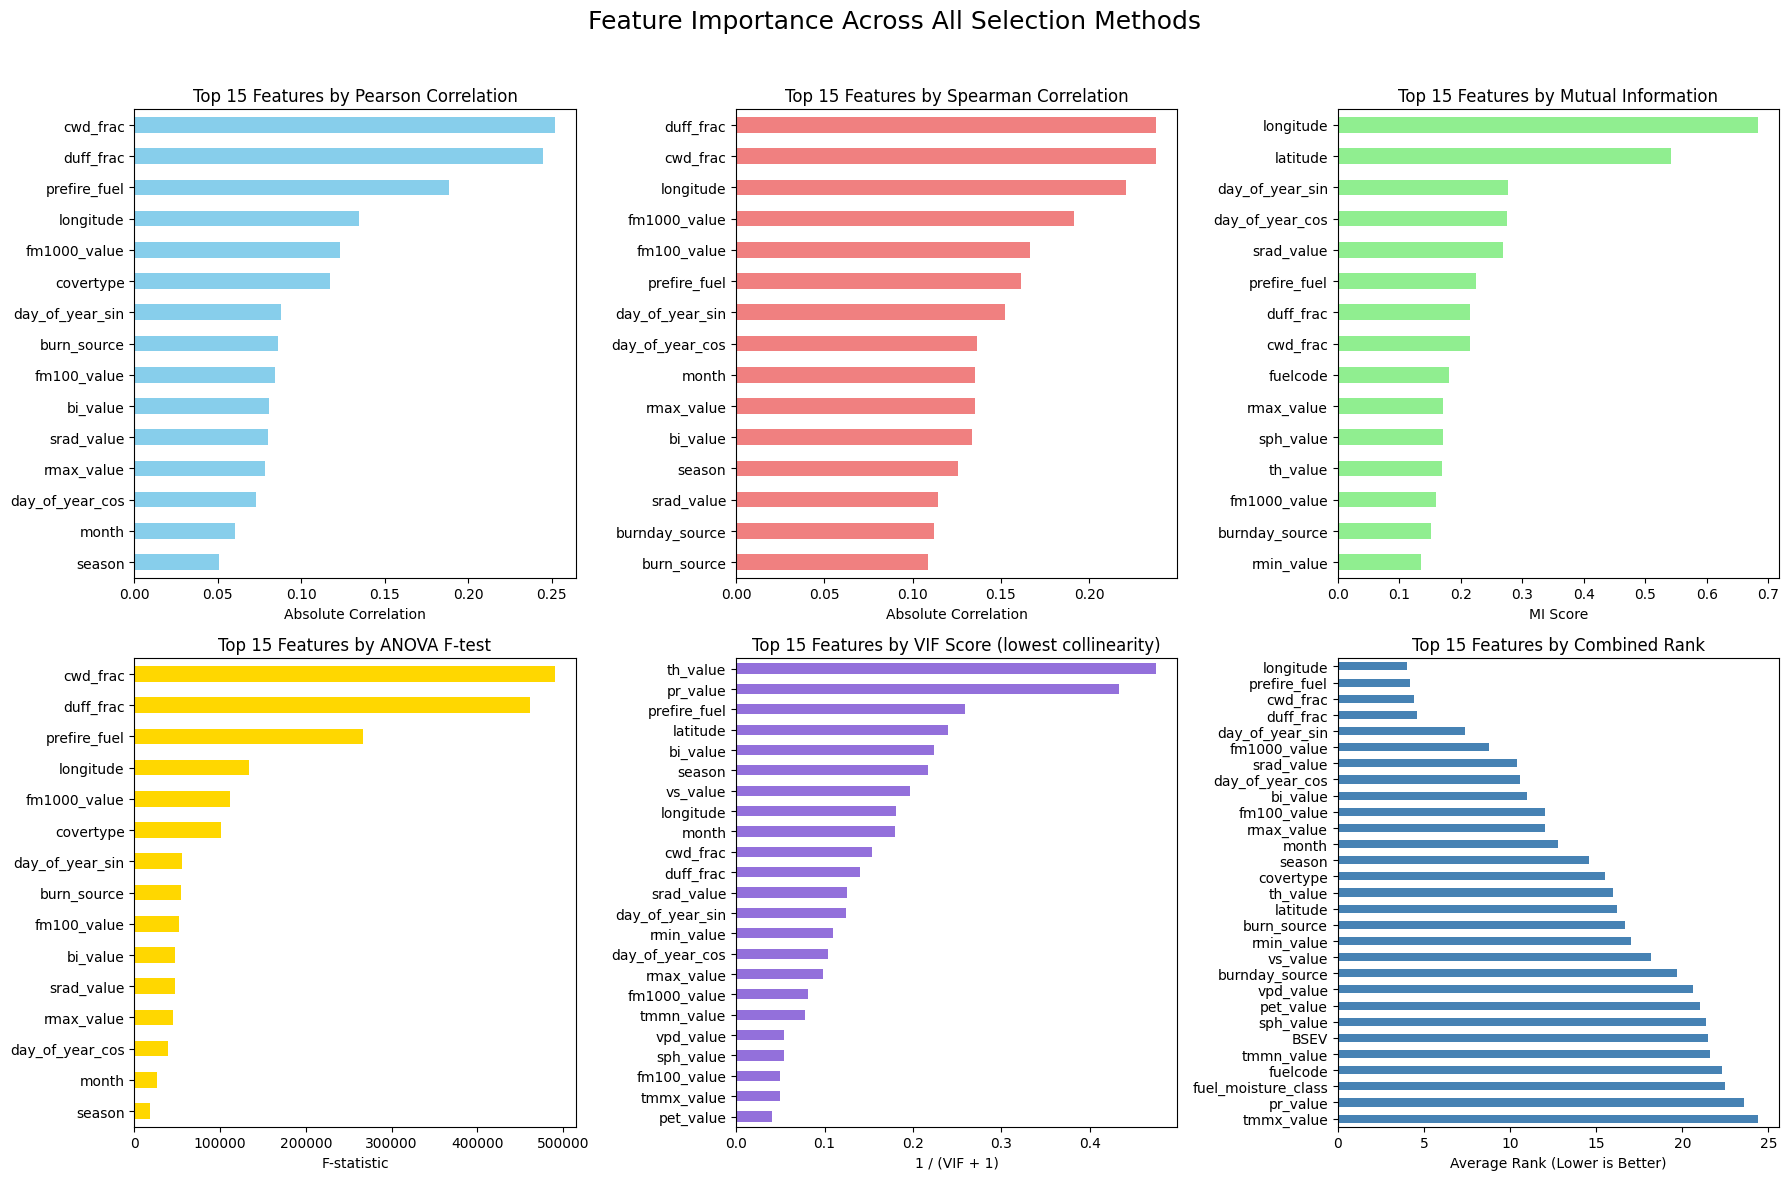

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

feature_scores['pearson_correlation'].abs().sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[0], color='skyblue'
)
axes[0].set_title('Top 15 Features by Pearson Correlation')
axes[0].set_xlabel('Absolute Correlation')
axes[0].invert_yaxis()

feature_scores['spearman_correlation'].abs().sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[1], color='lightcoral'
)
axes[1].set_title('Top 15 Features by Spearman Correlation')
axes[1].set_xlabel('Absolute Correlation')
axes[1].invert_yaxis()

feature_scores['mutual_information'].sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[2], color='lightgreen'
)
axes[2].set_title('Top 15 Features by Mutual Information')
axes[2].set_xlabel('MI Score')
axes[2].invert_yaxis()

feature_scores['anova_f'].sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[3], color='gold'
)
axes[3].set_title('Top 15 Features by ANOVA F-test')
axes[3].set_xlabel('F-statistic')
axes[3].invert_yaxis()

vif_data_sorted = vif_data.sort_values('VIF', ascending=True).head(23)
(1 / (vif_data_sorted['VIF'] + 1)).plot(
    kind='barh', ax=axes[4], color='mediumpurple'
)
axes[4].set_yticks(range(len(vif_data_sorted)))
axes[4].set_yticklabels(vif_data_sorted['Feature'])
axes[4].set_title('Top 15 Features by VIF Score (lowest collinearity)')
axes[4].set_xlabel('1 / (VIF + 1)')
axes[4].invert_yaxis()

rankings_sorted['avg_rank'].sort_values(ascending=True).head(29).plot(
    kind='barh', ax=axes[5], color='steelblue'
)
axes[5].set_title('Top 15 Features by Combined Rank')
axes[5].set_xlabel('Average Rank (Lower is Better)')
axes[5].invert_yaxis()


plt.suptitle('Feature Importance Across All Selection Methods', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
correlation_summary = feature_scores[['pearson_correlation', 'spearman_correlation']].copy()
correlation_summary['avg_correlation'] = correlation_summary.mean(axis=1)
correlation_summary = correlation_summary.sort_values('avg_correlation', ascending=False)

print("Top Features by Correlation (Pearson & Spearman):")
print(correlation_summary.head(10).round(3))
print("\n")

mi_summary = feature_scores[['mutual_information']].sort_values('mutual_information', ascending=False)
print("Top Features by Mutual Information:")
print(mi_summary.head(10).round(4))
print("\n")

anova_summary = feature_scores[['anova_f']].sort_values('anova_f', ascending=False)
print("Top Features by ANOVA F-test Score:")
print(anova_summary.head(10).round(2))
print("\n")

print("Top Features by VIF (Low VIF indicates low multicollinearity):")
print(vif_data.head(29))
print("\n")

print("=" * 60)
print("OVERALL FEATURE SELECTION SUMMARY")
print("=" * 60)
print(f"Total features analyzed: {len(feature_columns)}")
print("\nTop 10 features by combined ranking (all methods):")

for i, (feat, rank) in enumerate(rankings_sorted['avg_rank'].head(29).items()):
    scores_str = []

    if feat in feature_scores.index:
        pearson = feature_scores.loc[feat, 'pearson_correlation']
        mi = feature_scores.loc[feat, 'mutual_information']
        anova = feature_scores.loc[feat, 'anova_f']

        if not pd.isna(pearson):
            scores_str.append(f"Pearson: {pearson:.3f}")
        if not pd.isna(mi):
            scores_str.append(f"MI: {mi:.3f}")
        if not pd.isna(anova):
            scores_str.append(f"ANOVA: {anova:.1f}")

    vif_score = vif_data[vif_data['Feature'] == feat]['VIF']
    if not vif_score.empty:
        scores_str.append(f"VIF: {vif_score.values[0]:.2f}")

    if 'avg_score' in rankings.columns:
        avg_score = rankings.loc[feat, 'avg_score']
        scores_str.append(f"Avg Score: {avg_score:.3f}")
    if 'avg_score_norm' in rankings.columns:
        norm_score = rankings.loc[feat, 'avg_score_norm']
        scores_str.append(f"Norm Score: {norm_score:.3f}")

    print(f"  {i+1}. {feat} (avg rank: {rank:.2f})")
    if scores_str:
        print(f"     {', '.join(scores_str)}")


Top Features by Correlation (Pearson & Spearman):
                 pearson_correlation  spearman_correlation  avg_correlation
cwd_frac                       0.252                 0.238            0.245
duff_frac                      0.245                 0.238            0.241
longitude                      0.135                 0.221            0.178
prefire_fuel                   0.188                 0.161            0.175
fm1000_value                   0.123                 0.192            0.157
fm100_value                    0.084                 0.166            0.125
day_of_year_sin                0.088                 0.152            0.120
covertype                      0.117                 0.103            0.110
bi_value                       0.081                 0.134            0.107
rmax_value                     0.078                 0.135            0.107


Top Features by Mutual Information:
                 mutual_information
longitude                    0.6834
lati

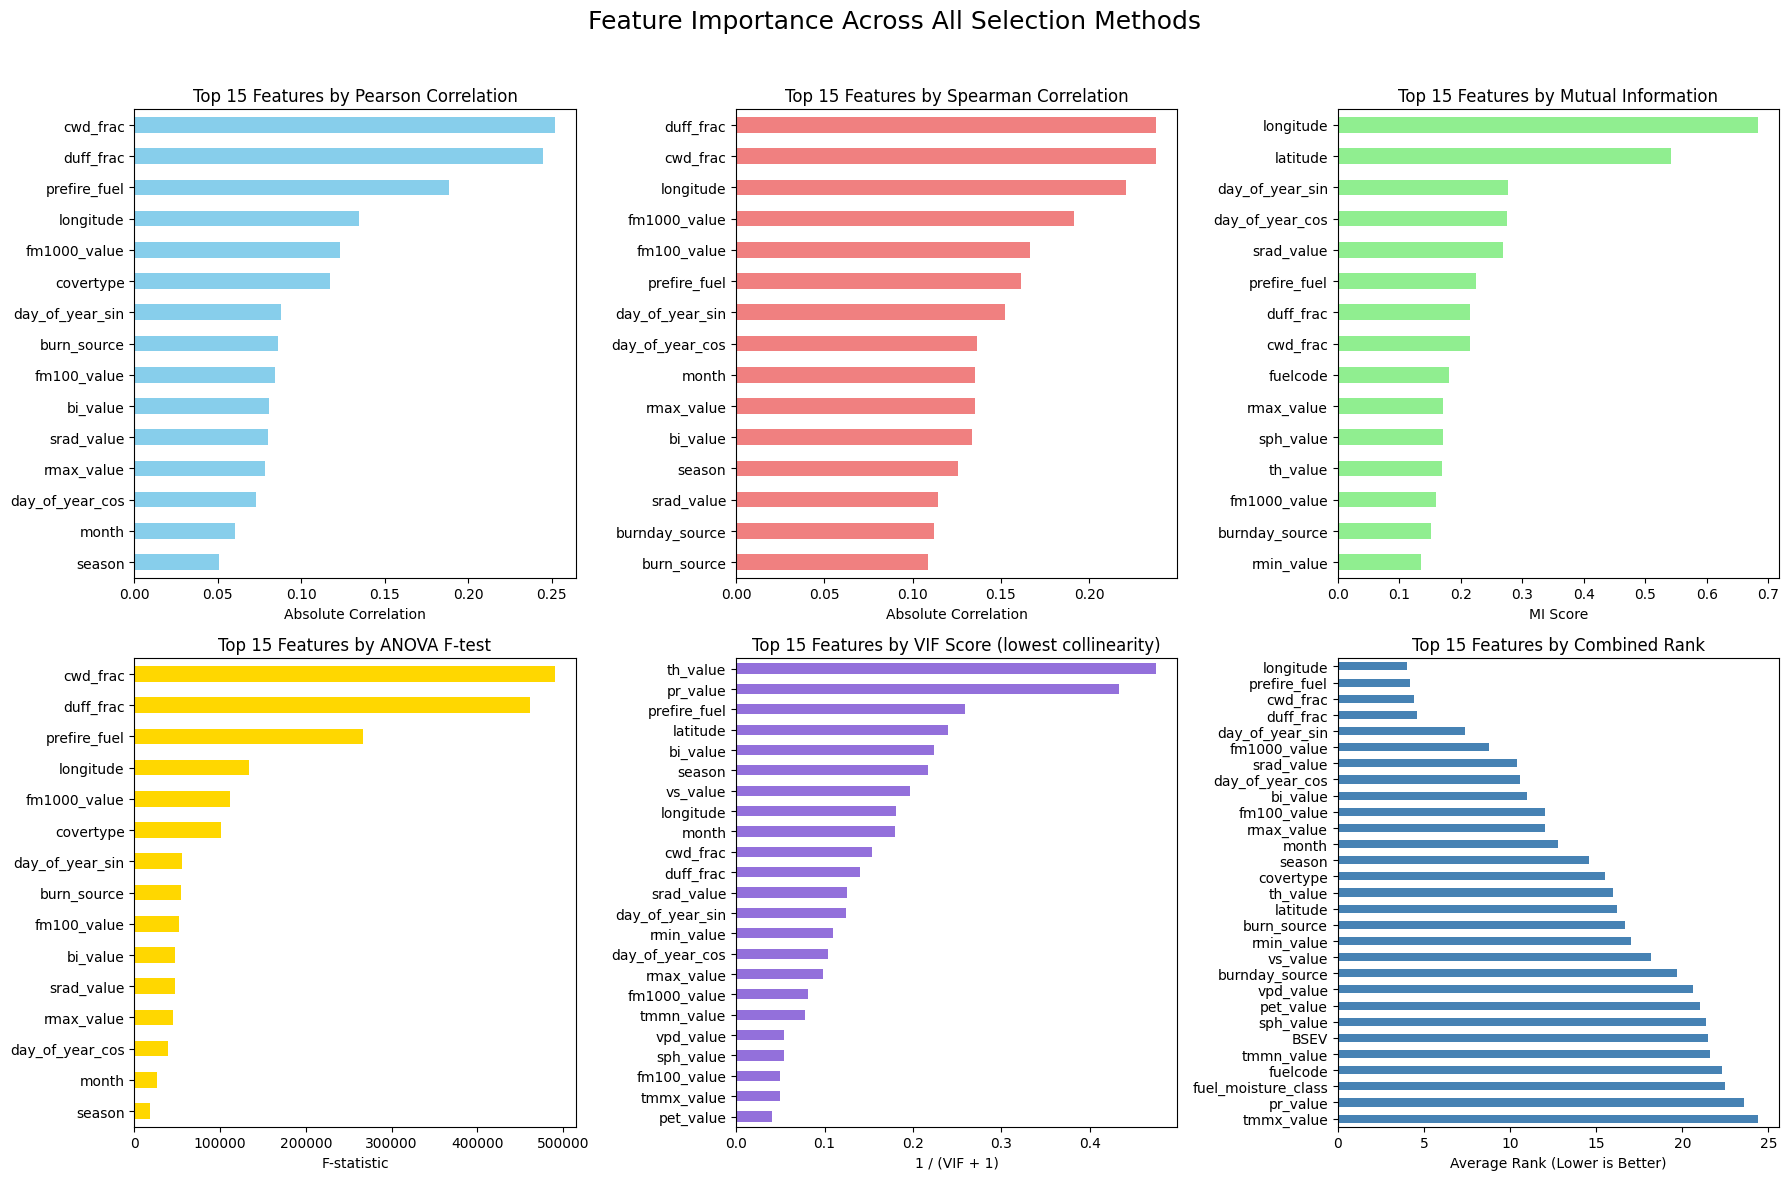

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

feature_scores['pearson_correlation'].abs().sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[0], color='skyblue'
)
axes[0].set_title('Top 15 Features by Pearson Correlation')
axes[0].set_xlabel('Absolute Correlation')
axes[0].invert_yaxis()

feature_scores['spearman_correlation'].abs().sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[1], color='lightcoral'
)
axes[1].set_title('Top 15 Features by Spearman Correlation')
axes[1].set_xlabel('Absolute Correlation')
axes[1].invert_yaxis()

feature_scores['mutual_information'].sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[2], color='lightgreen'
)
axes[2].set_title('Top 15 Features by Mutual Information')
axes[2].set_xlabel('MI Score')
axes[2].invert_yaxis()

feature_scores['anova_f'].sort_values(ascending=False).head(15).plot(
    kind='barh', ax=axes[3], color='gold'
)
axes[3].set_title('Top 15 Features by ANOVA F-test')
axes[3].set_xlabel('F-statistic')
axes[3].invert_yaxis()

vif_data_sorted = vif_data.sort_values('VIF', ascending=True).head(23)
(1 / (vif_data_sorted['VIF'] + 1)).plot(
    kind='barh', ax=axes[4], color='mediumpurple'
)
axes[4].set_yticks(range(len(vif_data_sorted)))
axes[4].set_yticklabels(vif_data_sorted['Feature'])
axes[4].set_title('Top 15 Features by VIF Score (lowest collinearity)')
axes[4].set_xlabel('1 / (VIF + 1)')
axes[4].invert_yaxis()

rankings_sorted['avg_rank'].sort_values(ascending=True).head(29).plot(
    kind='barh', ax=axes[5], color='steelblue'
)
axes[5].set_title('Top 15 Features by Combined Rank')
axes[5].set_xlabel('Average Rank (Lower is Better)')
axes[5].invert_yaxis()

plt.suptitle('Feature Importance Across All Selection Methods', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


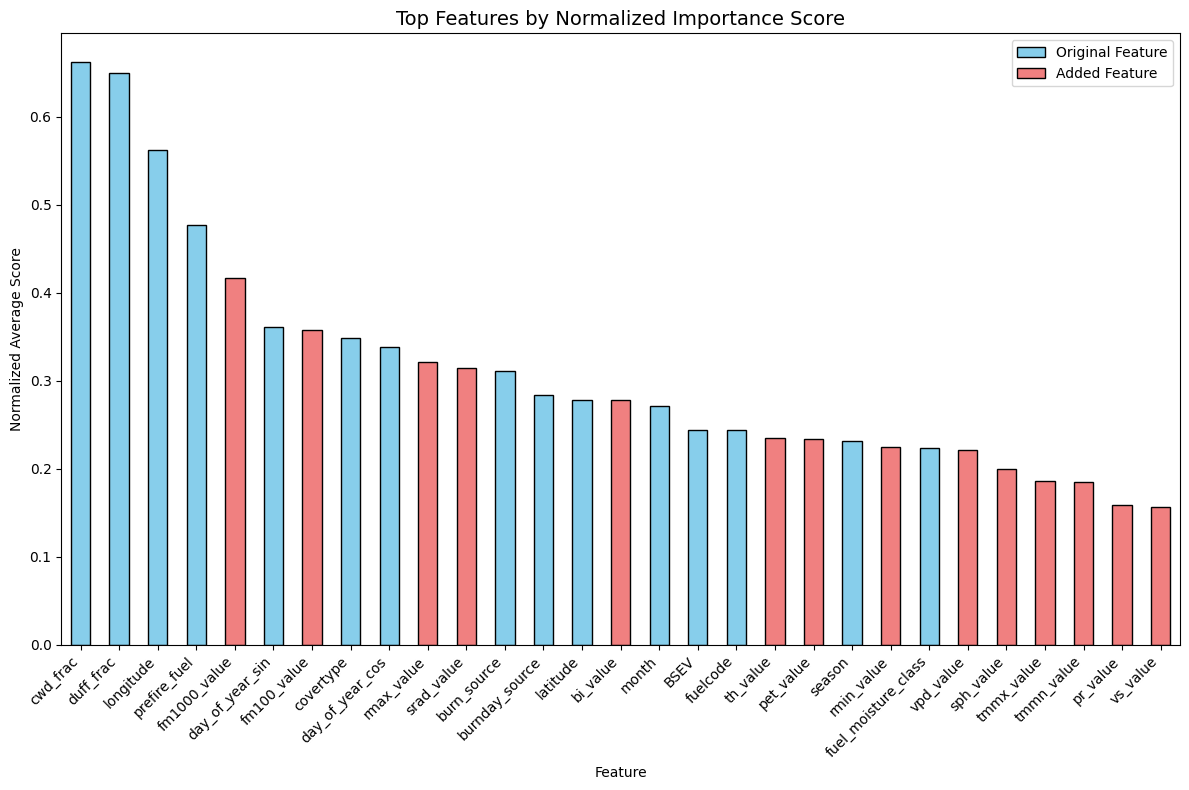

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(12, 8))

if rankings['avg_score_norm'].notnull().sum() > 0:
    top_features = rankings.sort_values('final_rank').head(29).sort_values('avg_score_norm', ascending=False)

    is_added = top_features.index.str.endswith('_value')

    bar_colors = ['lightcoral' if added else 'skyblue' for added in is_added]

    bars = top_features['avg_score_norm'].plot(
        kind='bar',
        ax=ax,
        color=bar_colors,
        edgecolor='black'
    )

    ax.set_title('Top Features by Normalized Importance Score', fontsize=14)
    ax.set_ylabel('Normalized Average Score')
    ax.set_xlabel('Feature')
    ax.set_xticklabels(top_features.index, rotation=45, ha='right')

    legend_handles = [
        Patch(facecolor='skyblue', edgecolor='black', label='Original Feature'),
        Patch(facecolor='lightcoral', edgecolor='black', label='Added Feature')
    ]
    ax.legend(handles=legend_handles, loc='upper right')

    plt.tight_layout()
    plt.show()



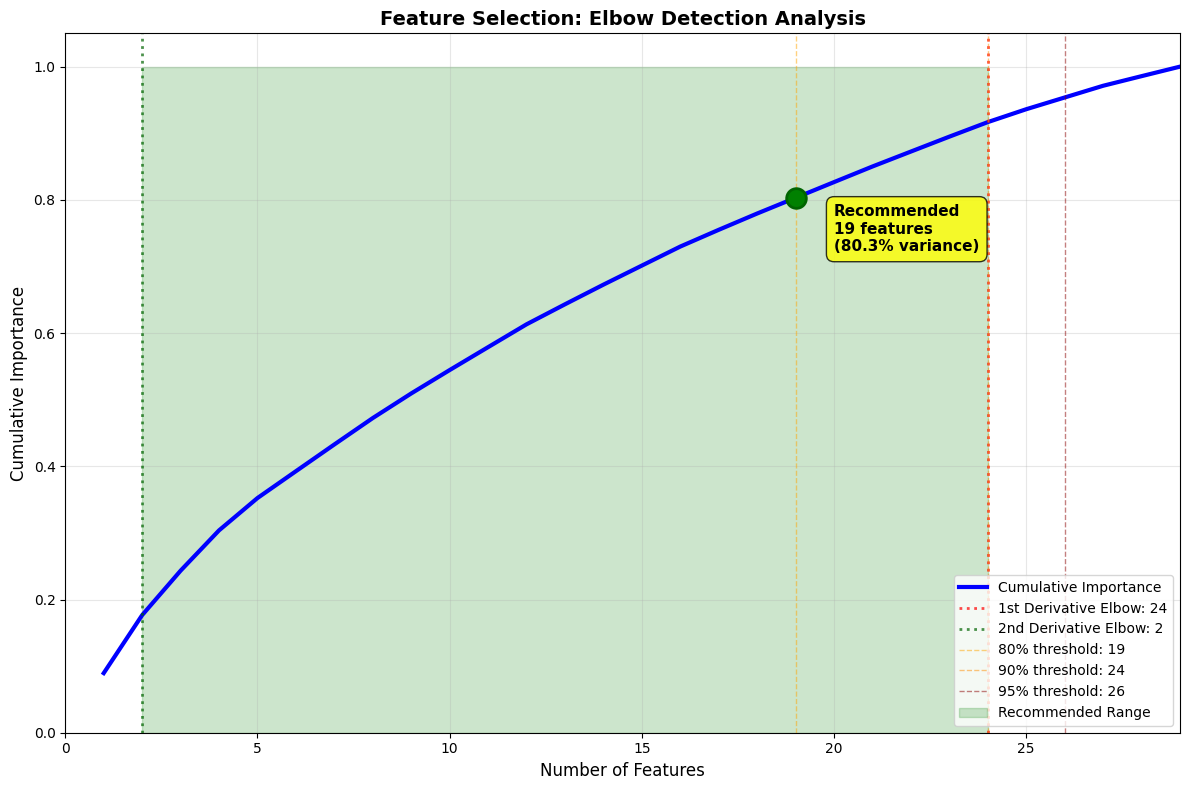

=== Feature Selection Analysis ===

Elbow Detection Results:
- 1st Derivative Elbow: 24 features (91.7% variance)
- 2nd Derivative Elbow: 2 features (17.7% variance)

Variance Thresholds:
- 80% variance: 19 features
- 90% variance: 24 features
- 95% variance: 26 features

Recommended Range: 2 to 24 features

PRIMARY RECOMMENDATION: Use 19 features
   - Captures 80.3% of total variance
   - Balanced between model complexity and completeness
   - Aligns with 80% variance threshold (common standard)

Top 10 Features by Normalized Score:
 1. Feature cwd_frac: score = 0.7461
 2. Feature duff_frac: score = 0.7264
 3. Feature longitude: score = 0.5565
 4. Feature prefire_fuel: score = 0.5047
 5. Feature fm1000_value: score = 0.4048
 6. Feature day_of_year_sin: score = 0.3360
 7. Feature covertype: score = 0.3349
 8. Feature fm100_value: score = 0.3307
 9. Feature day_of_year_cos: score = 0.3081
10. Feature rmax_value: score = 0.2929


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sorted_scores = rankings_sorted['avg_score_norm'].sort_values(ascending=False)
cumulative_importance = sorted_scores.cumsum() / sorted_scores.sum()

differences = np.diff(cumulative_importance.values)
threshold = 0.02
elbow_idx_fd = np.argmax(differences < threshold) + 1 if any(differences < threshold) else len(differences)

second_differences = np.diff(differences)
elbow_idx_sd = np.argmax(np.abs(second_differences)) + 2


threshold_80 = np.where(cumulative_importance.values >= 0.8)[0][0] + 1
threshold_90 = np.where(cumulative_importance.values >= 0.9)[0][0] + 1
threshold_95 = np.where(cumulative_importance.values >= 0.95)[0][0] + 1


lower_bound = min(elbow_idx_sd, elbow_idx_fd)

upper_bound = min(threshold_90, elbow_idx_fd)


if threshold_80 >= lower_bound and threshold_80 <= upper_bound:
    recommended = threshold_80
else:
    recommended = (lower_bound + upper_bound) // 2


plt.figure(figsize=(12, 8))


x = range(1, len(cumulative_importance) + 1)
plt.plot(x, cumulative_importance.values, 'b-', linewidth=3, label='Cumulative Importance')


plt.axvline(x=elbow_idx_fd, color='red', linestyle=':', linewidth=2, alpha=0.7, label=f'1st Derivative Elbow: {elbow_idx_fd}')
plt.axvline(x=elbow_idx_sd, color='darkgreen', linestyle=':', linewidth=2, alpha=0.7, label=f'2nd Derivative Elbow: {elbow_idx_sd}')


plt.axvline(x=threshold_80, color='orange', linestyle='--', linewidth=1, alpha=0.5, label=f'80% threshold: {threshold_80}')
plt.axvline(x=threshold_90, color='darkorange', linestyle='--', linewidth=1, alpha=0.5, label=f'90% threshold: {threshold_90}')
plt.axvline(x=threshold_95, color='darkred', linestyle='--', linewidth=1, alpha=0.5, label=f'95% threshold: {threshold_95}')


plt.fill_betweenx([0, 1], lower_bound, upper_bound, alpha=0.2, color='green', label='Recommended Range')


plt.scatter([recommended], [cumulative_importance.values[recommended-1]],
            color='green', s=200, zorder=5, edgecolor='darkgreen', linewidth=2)


box_text = f'Recommended\n{recommended} features\n({cumulative_importance.values[recommended-1]:.1%} variance)'
plt.text(recommended + 1, cumulative_importance.values[recommended-1] - 0.08,
         box_text,
         bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.8, edgecolor='black'),
         fontsize=11, fontweight='bold', ha='left')


plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Cumulative Importance', fontsize=12)
plt.title('Feature Selection: Elbow Detection Analysis', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right', fontsize=10)


plt.xlim(0, min(50, len(cumulative_importance)))
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()


print("=== Feature Selection Analysis ===\n")
print("Elbow Detection Results:")
print(f"- 1st Derivative Elbow: {elbow_idx_fd} features ({cumulative_importance.values[elbow_idx_fd-1]:.1%} variance)")
print(f"- 2nd Derivative Elbow: {elbow_idx_sd} features ({cumulative_importance.values[elbow_idx_sd-1]:.1%} variance)")
print(f"\nVariance Thresholds:")
print(f"- 80% variance: {threshold_80} features")
print(f"- 90% variance: {threshold_90} features")
print(f"- 95% variance: {threshold_95} features")
print(f"\nRecommended Range: {lower_bound} to {upper_bound} features")
print(f"\nPRIMARY RECOMMENDATION: Use {recommended} features")
print(f"   - Captures {cumulative_importance.values[recommended-1]:.1%} of total variance")
print(f"   - Balanced between model complexity and completeness")


if recommended == threshold_80:
    print("   - Aligns with 80% variance threshold (common standard)")
elif recommended < threshold_80:
    print(f"   - More aggressive than 80% threshold, but follows natural elbow")
else:
    print(f"   - More conservative, ensuring robust feature set")


print(f"\nTop 10 Features by Normalized Score:")
top_features = rankings_sorted.head(10)
for i, (idx, row) in enumerate(top_features.iterrows(), 1):
    print(f"{i:2d}. Feature {idx}: score = {row['avg_score_norm']:.4f}")